In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import random

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.distributions as distributions
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.nn import Module, Parameter
from datetime import datetime as dt
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 67686970
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
def read_data():
  # Load CSV into dataframe and format
  df = pd.read_csv('final_daily.csv')
  df['date']=pd.to_datetime(df['date'])
  df=df[df['date']<datetime.datetime(2023,1,1)]

  variable = ['price', 'demand']

  scaler = MinMaxScaler()
  df[variable] = scaler.fit_transform(df[variable].values.reshape(-1, len(variable)))

  VAL_PERC = 0.30

  n_train = int(len(df[:-365]) * (1 - VAL_PERC))

  dataframe_train = df[variable][0:n_train]
  train_df = dataframe_train.values.reshape(-1, len(variable))

  dataframe_val = df[variable][n_train:-365]
  val_df = dataframe_val.values.reshape(-1, len(variable))

  dataframe_test = df[variable][-365:]
  test_df = dataframe_test.values.reshape(-1, len(variable))

  dataframe_dataset = df[variable][0:df.shape[0]]
  dataset= dataframe_dataset.values.reshape(-1, len(variable))

  return df, train_df, val_df, test_df, dataset, scaler

In [ ]:
def to_sequences(dataset, seq_size): # seq_size is Number of time steps to look back 
                                       #Larger sequences (look further back) may improve forecasting.
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), :]
        x.append(window)
        y.append(dataset[i+seq_size, :])
    print(np.array(x).shape)
        
    return np.array(x),np.array(y)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]        

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, feature_size=250, num_layers=1, n_heads=2, dimfeedforward=512, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.src_mask = None
        self.d_model = d_model
        self.project_inp = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, dim_feedforward=dimfeedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.ln1 = nn.Linear(d_model, 512)
        self.ln2 = nn.Linear(512, 256)
        self.decoder = nn.Linear(256, feature_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(seq_size).to(device)
            self.src_mask = mask

        src = src.view(1, 2, -1)
        #src = src.view(src.size()[0], 2, -1)
        src = src.permute(2, 0, 1)
        src = self.project_inp(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        #output = self.activation(output)
        output = output.permute(1, 2, 0)
        output = self.ln1(output[:, -1, :])
        output = self.dropout(self.relu(output))
        output = self.ln2(output)
        output = self.dropout(self.relu(output))
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        x = torch.squeeze(x)

        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)


        # Returns the loss
        return yhat, loss.item()


    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
      early_stopping = EarlyStopping(patience=15)


      for epoch in range(1, n_epochs + 1):
          train_pred = []
          val_pred = []
          batch_losses = []
          validation_loss = 0
          training_loss = 0
          for x_batch, y_batch in train_loader:
              x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
              y_batch = y_batch.to(device)
              yhat, loss = self.train_step(x_batch, y_batch)
              batch_losses.append(loss)
              train_pred.append(yhat.detach().numpy())
          training_loss = np.mean(batch_losses)
          self.train_losses.append(training_loss)

          with torch.no_grad():
              batch_val_losses = []
              for x_val, y_val in val_loader:
                  x_val = x_val.view([batch_size, -1, n_features]).to(device)
                  y_val = y_val.to(device)
                  self.model.eval()
                  yhat = self.model(x_val)
                  val_loss = self.loss_fn(y_val, yhat).item()
                  batch_val_losses.append(val_loss)
                  val_pred.append(yhat.numpy())
              validation_loss = np.mean(batch_val_losses)
              self.val_losses.append(validation_loss)

          print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.10f}\t Validation loss: {validation_loss:.10f}")

          # early stopping
          early_stopping(validation_loss)
          if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break
      return np.array(train_pred), np.array(val_pred)


    def plot_losses(self):
      plt.plot(self.train_losses, label="Training loss")
      plt.plot(self.val_losses, label="Validation loss")
      plt.legend()
      plt.title("Losses")
      plt.show()
      plt.close()
    

    def evaluate(self, test_loader, batch_size=1, n_features=1):
    
      with torch.no_grad():
          testPredict = []
          testValues = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              testPredict.append(yhat.to(device).detach().numpy())
              testValues.append(y_test.to(device).detach().numpy())

      return np.array(testPredict), np.array(testValues)

In [ ]:
def plotting (dataset, trainPredict, valPredict, testPredict, fcs = None):
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
    ext = 0

    if fcs is not None:
      ext = fcs.shape[0]

    trainPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

    # shift val predictions for plotting
    valPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(trainPredict)+(seq_size*2)+1-1:len(trainPredict)+len(valPredict)+(seq_size*2), :] = valPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+len(valPredict)+(seq_size*3)+1:len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+1, :] = testPredict

    if fcs is not None:
      fcPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
      fcPredictPlot[:, :] = np.nan
      fcPredictPlot[len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+2:len(dataset)+ext-1, :] = fcs

    # plot baseline and predictions
    plt.plot(dataset, color='k', label='dataset')
    plt.plot(trainPredictPlot, color='b', label='train', linestyle='dashed')
    plt.plot(valPredictPlot, color='g', label='val', linestyle='dashed')
    plt.plot(testPredictPlot, color='r', label='test', linestyle='dashed')
    if fcs is not None:
      plt.plot(fcPredictPlot, color='m', label='forecasts', linestyle='dashed')
    plt.legend(loc="upper left")
    plt.title("Prediction")
    plt.xlabel("Time")
    plt.ylabel("Cases")
    mpl.rcParams['figure.dpi'] = 300
    plt.show()

    return

In [ ]:
df, train, val, test, dataset, scaler = read_data()

In [ ]:
seq_size = 16
batch_size = 1

# convert dataset into input/output
trainX, trainY = to_sequences(train, seq_size)
valX, valY = to_sequences(val, seq_size)
testX, testY = to_sequences(test, seq_size)

train_features = torch.Tensor(trainX)
train_targets = torch.Tensor(trainY)

val_features = torch.Tensor(valX)
val_targets = torch.Tensor(valY)

test_features = torch.Tensor(testX)
test_targets = torch.Tensor(testY)

train = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)

val = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

test = TensorDataset(test_features, test_targets)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=False)

(494, 16, 2)
(203, 16, 2)
(348, 16, 2)


[1/1000] Training loss: 0.0282220245	 Validation loss: 0.0534496529
[2/1000] Training loss: 0.0188605760	 Validation loss: 0.0442038085
[3/1000] Training loss: 0.0140187707	 Validation loss: 0.0376390716
[4/1000] Training loss: 0.0103110507	 Validation loss: 0.0315797666
[5/1000] Training loss: 0.0088527978	 Validation loss: 0.0281392526
[6/1000] Training loss: 0.0079765030	 Validation loss: 0.0265035916
[7/1000] Training loss: 0.0072879054	 Validation loss: 0.0262741903
[8/1000] Training loss: 0.0074716129	 Validation loss: 0.0243405041
[9/1000] Training loss: 0.0068035671	 Validation loss: 0.0228209224
[10/1000] Training loss: 0.0062848863	 Validation loss: 0.0214861287
[11/1000] Training loss: 0.0064403029	 Validation loss: 0.0207477895
[12/1000] Training loss: 0.0061913321	 Validation loss: 0.0194866911
[13/1000] Training loss: 0.0060434417	 Validation loss: 0.0187115897
[14/1000] Training loss: 0.0056747173	 Validation loss: 0.0175912610
[15/1000] Training loss: 0.0057627074	 Vali

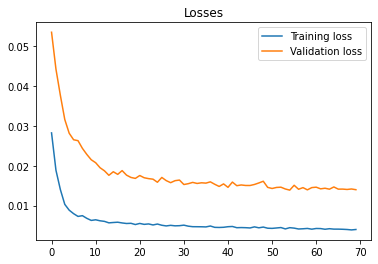

In [ ]:
input_dim = seq_size
output_dim = trainX.shape[2]
hidden_dim = 36
layer_dim = 1
dropout = 0
n_epochs = 1000
learning_rate = 1e-5
weight_decay = 0

model = Transformer(feature_size=output_dim, d_model=input_dim, num_layers=1, dropout=0)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

start = dt.now()

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
train_pred, val_pred = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

testPredict, testValues = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [ ]:
df_train = scaler.inverse_transform(train_pred.reshape(-1, 2))
df_val = scaler.inverse_transform(val_pred.reshape(-1, 2))
df_test = scaler.inverse_transform(testPredict.reshape(-1, 2))
dataset = scaler.inverse_transform(dataset)

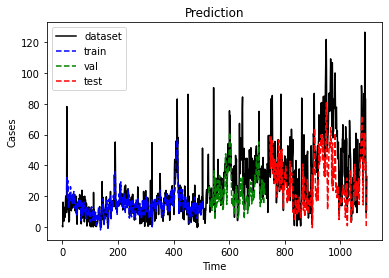

In [ ]:
plotting (dataset[:, 0].reshape(-1, 1), df_train[:, 0].reshape(-1, 1), df_val[:, 0].reshape(-1, 1), df_test[:, 0].reshape(-1, 1)) #plotting without inverse_transform

In [ ]:
np.square(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

621.2875644002302

In [ ]:
np.abs(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

19.793293757743534

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 0], scaler.inverse_transform(testY)[:, 0])

0.5972092375987983

In [ ]:
np.square(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

489325704.1631758

In [ ]:
np.abs(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

17509.55028735632

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 1], scaler.inverse_transform(testY)[:, 1])

0.04769337161993548